## Preparations



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import product               # Cartesian product for iterators

Make sure you put all of the given python files in the same directories before running this cell!


In [2]:
import sys, os

import gridworld as W                       # basic grid-world MDPs
import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P                            # helper-functions for plotting

In [3]:
!pip install ipympl

In [4]:
%matplotlib widget
plt.rcParams['figure.figsize'] = [9, 5]     # set default figure size
style = {                                   # global style for plots
    'border': {'color': 'red', 'linewidth': 0.5},
}

In [5]:
def to_one_hot_array(input_array, num_unique_values):

  num_unique_values = num_unique_values
  one_hot_array = np.zeros((len(input_array), num_unique_values), dtype=int)

  for i, val in enumerate(input_array):
    one_hot_array[i, val] = 1

  return one_hot_array




# Setting up the MDP

In [6]:
def setup_mdp(size, p_slip):
    # create our world
    world = W.IcyGridWorld(size= size, p_slip= p_slip)

    # set up the reward function
    reward = np.zeros(world.n_states) - 0.25
    reward[-1] = 1.0
    reward[8] = .6
    reward[9] = -0.6

    reward[5:8] = -0.6
    reward[16:20] = -0.6

    # set up terminal states
    terminal = [24]

    return world, reward, terminal




# Comment out the appropriate line of code

### Deterministic Environment (Problem 1 & 3) ###
# world, reward, terminal = setup_mdp(size = 5, p_slip = 0)

# ### Stochastic Environment (Problem 2 & 4) ###
world, reward, terminal = setup_mdp(size = 5, p_slip = 0.3)

# Generate Expert Trajectories

In [7]:
def generate_expert_trajectories_optimal(world, reward, terminal, num_trajectories = 200):
    n_trajectories = num_trajectories         # the number of "expert" trajectories
    discount = 0.9              # discount for constructing an "expert" policy
    weighting = lambda x: x**1  # down-weight less optimal actions
    start = [0]                  # starting states for the expert

    # compute the value-function
    value, Q = S.value_iteration(world.p_transition, reward, discount)


    # create our deterministic policy using the value function
    policy = S.optimal_policy_from_value(world, value)
    print('Expert policy:\n', policy)


    # a function that executes our deterministic policy by choosing actions according to it
    policy_exec = T.policy_adapter(policy)


    # generate trajectories
    tjs = list(T.generate_trajectories(n_trajectories, world, policy_exec, start, terminal))

    return tjs, policy, Q, True



def generate_expert_trajectories_suboptimal(world, reward, terminal, num_trajectories = 200):
    n_trajectories = num_trajectories         # the number of "expert" trajectories
    discount = 0.9              # discount for constructing an "expert" policy
    weighting = lambda x: x**1  # down-weight less optimal actions
    start = [0]                  # starting states for the expert

    # compute the value-function
    value, Q = S.value_iteration(world.p_transition, reward, discount)




    # # create our stochastic policy using the value function
    policy = S.stochastic_policy_from_value(world, value, w=weighting)
    print('Expert policy:\n', np.round(policy, 3))



    # # a function that executes our stochastic policy by choosing actions according to it
    policy_exec = T.stochastic_policy_adapter(policy)

    # generate trajectories
    tjs = list(T.generate_trajectories(n_trajectories, world, policy_exec, start, terminal))

    return tjs, policy, Q, False


#Comment out the appropriate Line of Code


# Fully Optimal Expert (Problem 1)
# trajectories, expert_policy, Q, optimal = generate_expert_trajectories_optimal(world, reward, terminal, num_trajectories = 20)

# Fully Optimal Expert (Problem 2)
# trajectories, expert_policy, Q, optimal = generate_expert_trajectories_optimal(world, reward, terminal, num_trajectories = 40)


# Suboptimal Expert (Problem 3)
# trajectories, expert_policy, Q, optimal = generate_expert_trajectories_suboptimal(world, reward, terminal, num_trajectories = 10)


# Suboptimal Expert (Problem 4)
trajectories, expert_policy, Q, optimal = generate_expert_trajectories_suboptimal(world, reward, terminal, num_trajectories = 40)



Expert policy:
 [[0.381 0.224 0.17  0.224]
 [0.434 0.135 0.202 0.229]
 [0.415 0.108 0.271 0.205]
 [0.153 0.108 0.522 0.218]
 [0.185 0.264 0.367 0.185]
 [0.295 0.15  0.358 0.197]
 [0.435 0.078 0.314 0.173]
 [0.583 0.056 0.241 0.12 ]
 [0.263 0.123 0.425 0.189]
 [0.142 0.245 0.541 0.072]
 [0.341 0.201 0.374 0.084]
 [0.446 0.125 0.326 0.103]
 [0.435 0.091 0.348 0.126]
 [0.375 0.07  0.385 0.17 ]
 [0.197 0.084 0.667 0.052]
 [0.282 0.202 0.408 0.108]
 [0.345 0.099 0.466 0.09 ]
 [0.376 0.05  0.505 0.069]
 [0.368 0.037 0.548 0.046]
 [0.119 0.036 0.81  0.035]
 [0.483 0.207 0.207 0.103]
 [0.634 0.091 0.212 0.063]
 [0.698 0.064 0.191 0.047]
 [0.756 0.045 0.165 0.034]
 [0.423 0.092 0.423 0.062]]


# Training a Behavioral Cloning Model on the trajectories of the expert

In [8]:
states = []
actions = []

In [9]:
for traject in trajectories:
  for t in traject._t:
    states.append(t[0])
    actions.append(t[1])

In [13]:
np.arange(285)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [10]:
print(len(states))
print(len(actions))
print(states)
print(actions)

657
657
[0, 0, 0, 0, 1, 1, 1, 6, 5, 6, 11, 10, 10, 11, 16, 21, 22, 23, 0, 0, 1, 1, 2, 3, 8, 9, 9, 14, 14, 19, 0, 0, 0, 0, 1, 2, 7, 8, 9, 14, 13, 8, 7, 8, 7, 8, 9, 14, 19, 0, 0, 1, 2, 3, 4, 4, 9, 14, 14, 13, 14, 14, 19, 19, 0, 0, 0, 1, 0, 1, 1, 6, 7, 8, 13, 18, 23, 18, 19, 0, 1, 2, 1, 6, 7, 8, 9, 14, 19, 0, 0, 0, 1, 0, 1, 0, 0, 5, 0, 0, 1, 1, 6, 11, 12, 17, 18, 23, 23, 0, 1, 0, 0, 0, 1, 6, 1, 2, 3, 2, 7, 8, 3, 8, 13, 14, 19, 0, 5, 0, 0, 0, 0, 0, 5, 10, 15, 15, 20, 21, 21, 22, 23, 0, 1, 0, 1, 2, 3, 4, 3, 8, 3, 8, 13, 18, 23, 18, 23, 0, 0, 5, 6, 7, 6, 11, 12, 17, 22, 22, 21, 22, 23, 0, 0, 0, 0, 1, 2, 2, 3, 2, 2, 3, 8, 7, 6, 11, 12, 13, 18, 23, 18, 19, 19, 19, 19, 0, 1, 2, 3, 2, 2, 3, 4, 4, 9, 9, 4, 4, 3, 8, 7, 12, 17, 22, 22, 23, 0, 0, 5, 0, 5, 10, 11, 12, 13, 14, 14, 9, 9, 4, 9, 9, 8, 13, 18, 19, 0, 0, 0, 5, 10, 10, 15, 10, 11, 6, 11, 10, 11, 16, 21, 22, 21, 16, 21, 22, 22, 23, 18, 23, 0, 0, 1, 2, 3, 4, 4, 9, 9, 4, 4, 4, 9, 14, 14, 14, 19, 0, 1, 0, 1, 2, 7, 6, 7, 8, 13, 14, 14, 19, 14, 1

# USE your favorite Supervised Learning Algorithm to train a model on the states and actions dataset where the states list is the input data and the actions list is the output. Once you trained your model extract a policy from it for each of the 25 states.

# Make sure you use 1-hot encoding for the states and actions spaces!

In [11]:
from sklearn.neural_network import MLPRegressor
import numpy as np

/Users/jamin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
inputs = list(range(25))
print(inputs)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [13]:
def from_one_hot_array(input_array):
    return (np.argmax(input_array, axis=1))

In [14]:
### FILL IN THE CODE ########
# Make sure you use 1-hot encoding for the states and actions spaces!

def model (states, actions):
    states_array = to_one_hot_array(states, 25)
    actions_array = to_one_hot_array(actions, 4)
    
    model = MLPRegressor(hidden_layer_sizes=(25, 4), max_iter=1000)
    model.fit(states_array, actions_array)
    
    state_space = list(range(25))
    encoded_state_space = to_one_hot_array(state_space, 25)
    
    encoded_policy = model.predict(encoded_state_space)
    decoded_policy = from_one_hot_array(encoded_policy)
    
    return decoded_policy
    

bc_policy = model(states, actions)  #This should be an array of shape (25, ) with entries being either 0, 1, 2 or 3 (corresponding to the actions for each of the 25 states)

assert bc_policy.shape == (25, )

In [15]:
# bc_policy = np.argmax(model.predict(state_encoder.transform(np.arange(25).reshape(-1, 1))), axis =1)

In [16]:
bc_policy

array([0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0, 2, 2, 0, 0,
       0, 0, 0])

In [17]:
expert_policy

array([[0.38085611, 0.2244782 , 0.1701875 , 0.2244782 ],
       [0.43445021, 0.13489045, 0.20180037, 0.22885898],
       [0.41531955, 0.10814425, 0.27124257, 0.20529363],
       [0.15275239, 0.1076974 , 0.52167283, 0.21787738],
       [0.18482022, 0.26361712, 0.36674245, 0.18482022],
       [0.29529104, 0.14964527, 0.3576808 , 0.19738289],
       [0.43503448, 0.07750612, 0.31401142, 0.17344798],
       [0.58282682, 0.05588928, 0.24096148, 0.12032242],
       [0.26254559, 0.12325162, 0.42548312, 0.18871967],
       [0.14246734, 0.24519624, 0.54053986, 0.07179656],
       [0.34084862, 0.20108733, 0.37393382, 0.08413023],
       [0.44555894, 0.12517898, 0.3259179 , 0.10334418],
       [0.43505629, 0.09096567, 0.34795332, 0.12602472],
       [0.37459984, 0.0702525 , 0.38522407, 0.16992359],
       [0.19687559, 0.08409246, 0.66714246, 0.0518895 ],
       [0.28235947, 0.20166735, 0.40752418, 0.108449  ],
       [0.34513613, 0.09898745, 0.46564725, 0.09022917],
       [0.3761867 , 0.05018279,

In [18]:
from google.colab import output
output.enable_custom_widget_manager()

ModuleNotFoundError: No module named 'google.colab'

# Plot of the MDP (with corresponding reward and expert behavior)





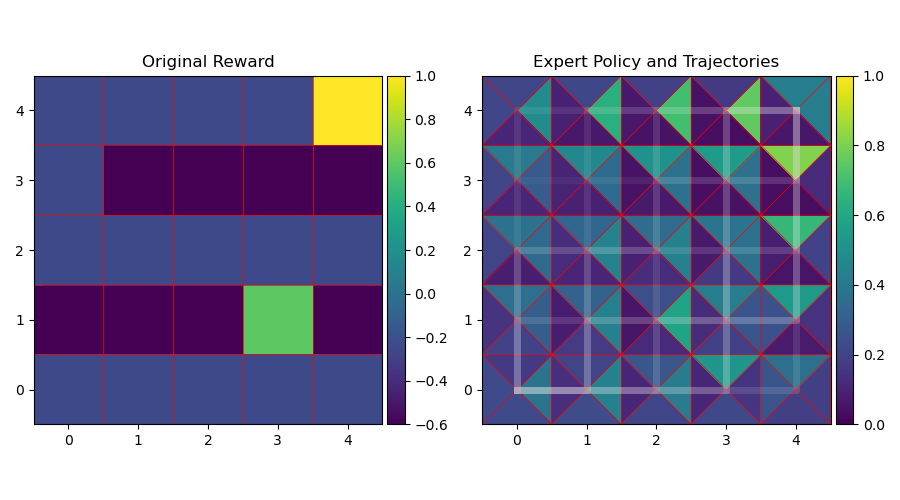

In [19]:
fig = plt.figure()
ax = fig.add_subplot(121)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(122)
ax.title.set_text('Expert Policy and Trajectories')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)



if optimal:
  p = P.plot_stochastic_policy(ax, world, to_one_hot_array(expert_policy, num_unique_values=4), **style)
else:
  p = P.plot_stochastic_policy(ax, world, expert_policy, **style)







for t in trajectories:
    P.plot_trajectory(ax, world, t, lw=5, color='white', alpha=0.025)


fig.colorbar(p, cax=cax)


fig.tight_layout()
plt.show()

## With that done, we have all the prequisites we need to run the MaxEnt IRL algorithm. We need to define some helper functions first

In [20]:
def feature_expectation_from_trajectories(features, trajectories):
    n_states, n_features = features.shape

    fe = np.zeros(n_features)

    for t in trajectories:                  # for each trajectory
        for s in t.states():                # for each state in trajectory
            fe += features[s, :]            # sum-up features

    return fe / len(trajectories)           # average over trajectories

In [21]:
def initial_probabilities_from_trajectories(n_states, trajectories):
    p = np.zeros(n_states)

    for t in trajectories:                  # for each trajectory
        p[t.transitions()[0][0]] += 1.0     # increment starting state

    return p / len(trajectories)            # normalize

In [22]:
def compute_expected_svf(p_transition, p_initial, terminal, reward, eps=1e-5):
    n_states, _, n_actions = p_transition.shape
    nonterminal = set(range(n_states)) - set(terminal)  # nonterminal states

    # Backward Pass
    # 1. initialize at terminal states
    zs = np.zeros(n_states)                             # zs: state partition function
    zs[terminal] = 1.0

    # 2. perform backward pass
    for _ in range(2 * n_states):                       # longest trajectory: n_states
        # reset action values to zero
        za = np.zeros((n_states, n_actions))            # za: action partition function

        # for each state-action pair
        for s_from, a in product(range(n_states), range(n_actions)):

            # sum over s_to
            for s_to in range(n_states):
                za[s_from, a] += p_transition[s_from, s_to, a] * np.exp(reward[s_from]) * zs[s_to]

        # sum over all actions
        zs = za.sum(axis=1)

    # 3. compute local action probabilities
    p_action = za / zs[:, None]

    # Forward Pass
    # 4. initialize with starting probability
    d = np.zeros((n_states, 2 * n_states))              # d: state-visitation frequencies
    d[:, 0] = p_initial

    # 5. iterate for N steps
    for t in range(1, 2 * n_states):                    # longest trajectory: n_states

        # for all states
        for s_to in range(n_states):

            # sum over nonterminal state-action pairs
            for s_from, a in product(nonterminal, range(n_actions)):
                d[s_to, t] += d[s_from, t-1] * p_action[s_from, a] * p_transition[s_from, s_to, a]

    # 6. sum-up frequencies
    return d.sum(axis=1)

In [23]:
def maxent_irl(p_transition, features, terminal, trajectories, optim, init, eps=1e-4):
    n_states, _, n_actions = p_transition.shape
    _, n_features = features.shape

    # compute feature expectation from trajectories
    e_features = feature_expectation_from_trajectories(features, trajectories)

    # compute starting-state probabilities from trajectories
    p_initial = initial_probabilities_from_trajectories(n_states, trajectories)

    # gradient descent optimization
    omega = init(n_features)        # initialize our parameters
    delta = np.inf                  # initialize delta for convergence check

    optim.reset(omega)              # re-start optimizer
    while delta > eps:              # iterate until convergence
        omega_old = omega.copy()

        # compute per-state reward from features
        reward = features.dot(omega)

        # compute gradient of the log-likelihood
        e_svf = compute_expected_svf(p_transition, p_initial, terminal, reward)
        grad = e_features - features.T.dot(e_svf)

        # perform optimization step and compute delta for convergence
        optim.step(grad)

        # re-compute detla for convergence check
        delta = np.max(np.abs(omega_old - omega))

    # re-compute per-state reward and return
    return features.dot(omega)

# True Reward vs MaxEnt Reward

## Also plot the optimal policies derived from both reward functions as well as from BC

In [24]:
# set up features: we use one feature vector per state
features = W.state_features(world)

# choose our parameter initialization strategy:
#   initialize parameters with constant
init = O.Constant(1.0)

# choose our optimization strategy:
#   we select exponentiated stochastic gradient descent with linear learning-rate decay
optim = O.ExpSga(lr=O.linear_decay(lr0=0.2))

# Computing the R function through inverse reinforcement learning
reward_maxent = maxent_irl(world.p_transition, features, terminal, trajectories, optim, init)

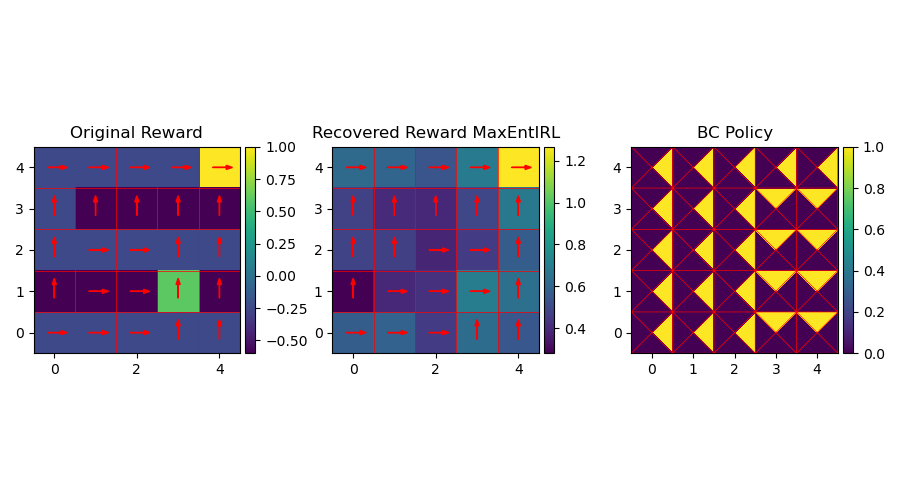

In [25]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.title.set_text('Original Reward')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward, 0.9), color='red')
fig.colorbar(p, cax=cax)

ax = fig.add_subplot(132)
ax.title.set_text('Recovered Reward MaxEntIRL')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_state_values(ax, world, reward_maxent, **style)
P.plot_deterministic_policy(ax, world, S.optimal_policy(world, reward_maxent, 0.9), color='red')
fig.colorbar(p, cax=cax)


ax = fig.add_subplot(133)
ax.title.set_text('BC Policy')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
p = P.plot_stochastic_policy(ax, world, to_one_hot_array(bc_policy, num_unique_values=4), **style)

fig.colorbar(p, cax=cax)


fig.tight_layout()
plt.show()

In [26]:
print('True reward:', reward)


True reward: [-0.25 -0.25 -0.25 -0.25 -0.25 -0.6  -0.6  -0.6   0.6  -0.6  -0.25 -0.25
 -0.25 -0.25 -0.25 -0.25 -0.6  -0.6  -0.6  -0.6  -0.25 -0.25 -0.25 -0.25
  1.  ]


In [27]:
print('Learnt MaxEnt reward:', np.round(reward_maxent,2 ))

Learnt MaxEnt reward: [0.57 0.59 0.45 0.63 0.55 0.28 0.39 0.42 0.69 0.64 0.48 0.47 0.38 0.45
 0.57 0.47 0.4  0.39 0.49 0.68 0.62 0.6  0.54 0.69 1.27]


In [28]:
def calculate_value_function(reward, dynamics, policy, discount_factor=0.9, tol=1e-6, max_iterations=1000):
    num_states, _, num_actions = dynamics.shape
    value_function = np.zeros(num_states)


    for iteration in range(max_iterations):
        prev_value_function = np.copy(value_function)

        for state in range(num_states):
            action_probs = policy[state, :]
            action_value = 0

            for action in range(num_actions):
                next_state_values = np.sum(dynamics[state, :, action] * prev_value_function)
                action_value += action_probs[action] * (reward[state] + discount_factor * next_state_values)

            value_function[state] = action_value

        if np.max(np.abs(value_function - prev_value_function)) < tol:
            break

    return value_function

Value function using the true Reward functions

# Value function plots

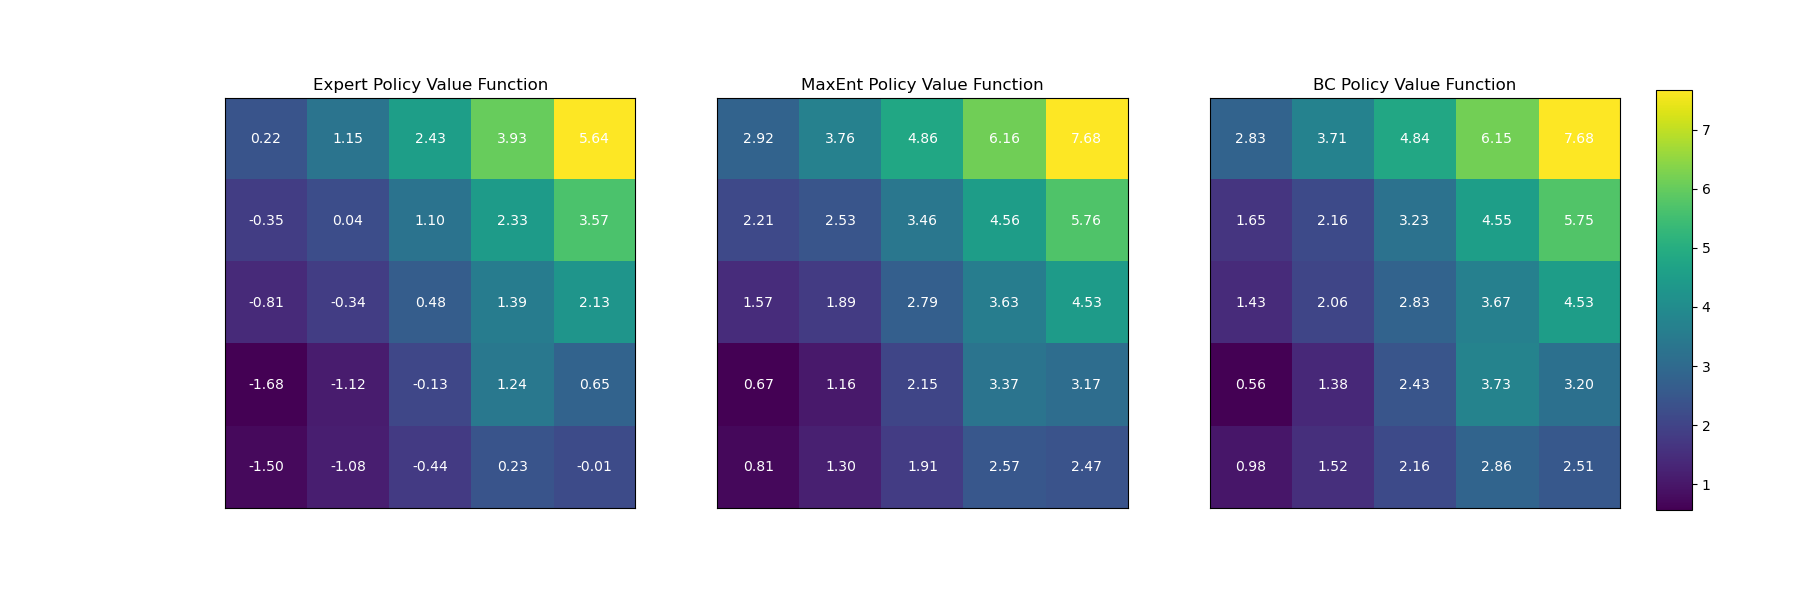

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Create sample 1D arrays of size 25
if optimal:
  values1 = calculate_value_function(reward, world.p_transition, to_one_hot_array(expert_policy, num_unique_values=4))
else:
  values1 = calculate_value_function(reward, world.p_transition, expert_policy)

values2 = calculate_value_function(reward, world.p_transition,to_one_hot_array(S.optimal_policy(world, reward_maxent, 0.9), num_unique_values=4) )
values3 = calculate_value_function(reward, world.p_transition, to_one_hot_array(bc_policy, num_unique_values=4))

# Create subplots in a row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Iterate through each subplot
for ax, values in zip(axes, [values1, values2, values3]):
    # Rearrange the values to match the desired corner arrangement
    values_arranged = np.flipud(values.reshape(5, 5))

    # Use the 'viridis' colormap to map values to colors
    im = ax.imshow(values_arranged, cmap='viridis', interpolation='nearest')

    # Add text annotations for each cell
    for i in range(5):
        for j in range(5):
            ax.text(j, i, f'{values_arranged[i, j]:.2f}', ha='center', va='center', color='white')

    # Set title for each subplot
    # ax.set_title(f'Array {values[0]:.2f} - {values[-1]:.2f}')

    # Remove x and y ticks for better layout
    ax.set_xticks([])
    ax.set_yticks([])

# Add a colorbar
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position of colorbar
fig.colorbar(im, cax=cax)



# Adjust layout for better spacing
# plt.tight_layout()

axes[0].set_title('Expert Policy Value Function')
axes[1].set_title('MaxEnt Policy Value Function')
axes[2].set_title('BC Policy Value Function')


plt.show()


# References

* [Abbel & Ng 2004]: https://doi.org/10.1145/1015330.1015430
* [Bishop 2006]: https://www.springer.com/us/book/9780387310732
* [Jaynes 1957]: https://doi.org/10.1103/physrev.106.620
* [Kivinen et. al. 1997]: https://doi.org/10.1006/inco.1996.2612
* [Ng et al. 99]: https://dl.acm.org/citation.cfm?id=645528.657613
* [Osa et al. 2018]: https://arxiv.org/abs/1811.06711
* [Ziebart et al. 2008]: http://www.cs.cmu.edu/~bziebart/publications/maximum-entropy-inverse-reinforcement-learning.html
* [Ziebart 2010]: https://www.cs.cmu.edu/~bziebart/publications/thesis-bziebart.pdf
* Reused code from: https://github.com/qzed/irl-maxent